In [1]:
%matplotlib inline
from matplotlib import style
style.use('seaborn')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd

In [3]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [4]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect

In [5]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [6]:
#set start and end date
start_date=dt.datetime(2020,9,1)
end_date=dt.datetime(2020,9,8)

In [7]:
# reflect an existing database into a new model
Base=automap_base()
# reflect the tables
Base.prepare(engine,reflect=True)

In [8]:
# We can view all of the classes that automap found
inspect(engine).get_table_names()

['measurement', 'station']

In [9]:
# Save references to each table
Measurement=Base.classes.measurement
Station=Base.classes.station

In [10]:
#Column Names Measurement
m_results=inspect(engine).get_columns("measurement")
for result in m_results:
    print(result["name"],result["type"])

id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


In [11]:
#Column Names Station
s_results=inspect(engine).get_columns("station")
for result in s_results:
    print(result["name"],result["type"])   

id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


In [12]:
# Create our session (link) from Python to the DB
session=Session(engine)

# Exploratory Climate Analysis

In [13]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results
# Calculate the date 1 year ago from the last data point in the database
last_date=session.query(Measurement.date).order_by(Measurement.date.desc()).first()[0]
last_date=dt.datetime.strptime(last_date,"%Y-%m-%d")
year_ago=last_date-dt.timedelta(days=365)
# Perform a query to retrieve the data and precipitation scores
precip_data=session.query(Measurement.date, Measurement.prcp).filter(Measurement.date >= year_ago).all()
# Save the query results as a Pandas DataFrame and set the index to the date column
precip_df=pd.DataFrame(precip_data, columns=["date","prcp"])
# Sort the dataframe by date
precip_df["date"]=pd.to_datetime(precip_df["date"], format="%Y-%m-%d")
precip_df=precip_df.sort_values(by="date",ascending=False)
precip_df=precip_df.reset_index(drop=True)
precip_df.head()

,date,prcp
0,2017-08-23,0.45
1,2017-08-23,0.08
2,2017-08-23,0.00
3,2017-08-23,0.00
4,2017-08-22,0.00


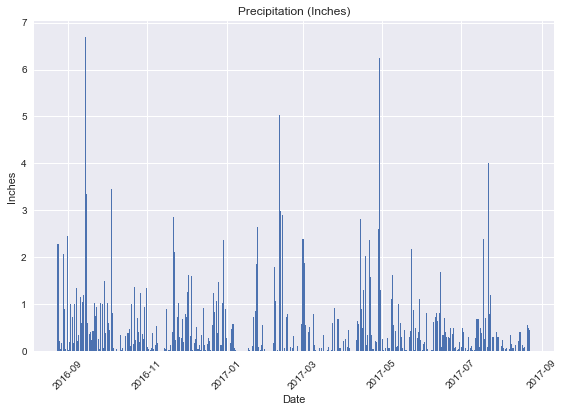

In [14]:
# Use Pandas Plotting with Matplotlib to plot the data
plt.bar(precip_df["date"],precip_df["prcp"])
plt.title("Precipitation (Inches)")
plt.xlabel("Date")
plt.ylabel("Inches")
plt.tight_layout()
plt.xticks(rotation=45)
plt.show()

In [15]:
# Use Pandas to calcualte the summary statistics for the precipitation data
precip_df.describe()

,prcp
count,2015.000000
mean,0.176462
std,0.460288
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


In [16]:
# Design a query to show how many stations are available in this dataset?
station_count=session.query(Station.station).count()
station_count

9

In [17]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
session.query(Station.id,Station.station, func.count(Measurement.station)).\
    filter(Station.station==Measurement.station).\
    group_by(Station.station).\
    order_by(func.count(Measurement.station).desc()).all()


[(7, 'USC00519281', 2772),
 (1, 'USC00519397', 2724),
 (2, 'USC00513117', 2709),
 (6, 'USC00519523', 2669),
 (9, 'USC00516128', 2612),
 (3, 'USC00514830', 2202),
 (8, 'USC00511918', 1979),
 (4, 'USC00517948', 1372),
 (5, 'USC00518838', 511)]

In [18]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature of the most active station?
[(low_temp, max_temp, avg_temp)]=session.query(func.min(Measurement.tobs),func.max(Measurement.tobs),func.avg(Measurement.tobs)).\
    filter(Station.station==Measurement.station).\
    filter(Station.id==7).all()
print(f"""The low temp is {low_temp}. 
The max temp is {max_temp}. 
The avg temp is {avg_temp}.""")


The low temp is 54.0. 
The max temp is 85.0. 
The avg temp is 71.66378066378067.


In [19]:
# Choose the station with the highest number of temperature observations.
session.query(Station.id,Station.station, func.count(Measurement.tobs)).\
    filter(Station.station==Measurement.station).\
    group_by(Station.station).\
    order_by(func.count(Measurement.station).desc()).first()

(7, 'USC00519281', 2772)

In [20]:
# Query the last 12 months of temperature observation data for this station
temp_data=session.query(Measurement.date, Measurement.tobs).\
    filter(Measurement.station == "USC00519281").\
    filter(Measurement.date >= year_ago).\
    order_by(Measurement.date.desc()).all()
temp_df=pd.DataFrame(temp_data,columns=["date","temp"])
temp_df.head()

,date,temp
0,2017-08-18,79.0
1,2017-08-17,76.0
2,2017-08-16,76.0
3,2017-08-15,77.0
4,2017-08-14,77.0


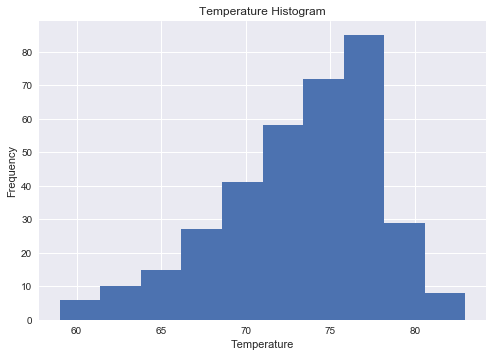

In [21]:
#Plot results on a histogram
plt.hist(temp_df["temp"])
plt.title("Temperature Histogram")
plt.xlabel("Temperature")
plt.ylabel("Frequency")
plt.show()

## Bonus Challenge Assignment

In [22]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [23]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.


In [24]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)


In [25]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation



In [26]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]

In [27]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip

# Use the start and end date to create a range of dates

# Stip off the year and save a list of %m-%d strings

# Loop through the list of %m-%d strings and calculate the normals for each date


In [28]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index


In [29]:
# Plot the daily normals as an area plot with `stacked=False`
